In [1]:
import pandas as pd

# Load the Excel file
file_path = '/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Data file for students.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load the "GL" sheet
gl_data = pd.read_excel(file_path, sheet_name='GL')

# Calculate the IQR for each Account_key's Details corresponding 'Amount'
def calculate_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return IQR, Q1, Q3

# Function to identify outliers using IQR
def identify_outliers(data, Q1, Q3, IQR):
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Group data by Account_key and Details
grouped_data = gl_data.groupby(['Account_key', 'Details'])

# Initialize results dictionary
results = []

# Iterate through each group and calculate outliers
for (account_key, details), group in grouped_data:
    amount_data = group['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Append results
    results.append({
        'Account_key': account_key,
        'Details': details,
        'Total Data Points': len(amount_data),
        'Number of Outliers': len(outliers)
    })

# Convert results to DataFrame for display
results_df = pd.DataFrame(results)

In [2]:
#generate the output excel file of results_df
results_df.to_excel('/Users/sishengliang/Desktop/Intern SF/Anomaly Detection in GL/Anomaly Detection Results.xlsx', index=False)

In [4]:
def display_outliers_summary(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Calculate IQR and identify outliers
    amount_data = filtered_data['Amount']
    IQR, Q1, Q3 = calculate_iqr(amount_data)
    outliers = identify_outliers(amount_data, Q1, Q3, IQR)
    
    # Create a summary DataFrame
    summary = pd.DataFrame({
        'Account_key': [account_key],
        'Details': [details],
        'Total Data Points': [len(amount_data)],
        'Number of Outliers': [len(outliers)]
    })
    
    # Display the summary
    print(summary)

In [5]:
# Example usage
display_outliers_summary(gl_data, 120, 'Credit Expenses')

   Account_key          Details  Total Data Points  Number of Outliers
0          120  Credit Expenses               2226                 123


In [6]:
import matplotlib.pyplot as plt

def show_boxplot(gl_data, account_key, details):
    # Filter data based on the specified Account_key and Details
    filtered_data = gl_data[(gl_data['Account_key'] == account_key) & (gl_data['Details'] == details)]
    
    # Check if the filtered data is empty
    if filtered_data.empty:
        print(f"No data found for Account_key: {account_key} and Details: {details}")
        return
    
    # Create a boxplot for the Amount column of the filtered data
    plt.figure(figsize=(10, 6))
    plt.boxplot(filtered_data['Amount'], vert=False)
    plt.title(f'Boxplot for Account_key: {account_key} and Details: {details}')
    plt.xlabel('Amount')
    plt.show()



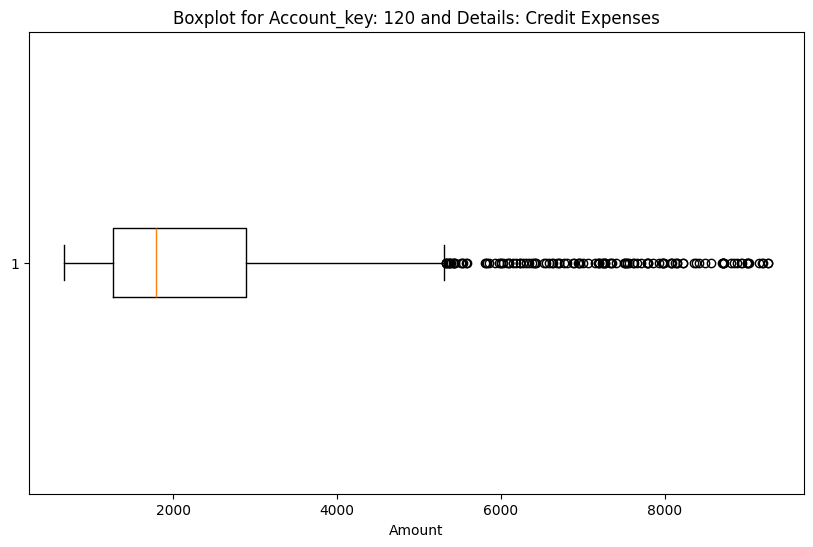

In [7]:
# Example usage
show_boxplot(gl_data, 120, 'Credit Expenses')

In [12]:
#Isolation Forest Algorithm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest


# Step 1: Convert the 'Date' column to numerical format
gl_data['Date'] = pd.to_datetime(gl_data['Date'])
gl_data['Date'] = gl_data['Date'].map(pd.Timestamp.toordinal)

# Step 2: Encode the 'Details' column using one-hot encoding
encoder = OneHotEncoder()
encoded_details = encoder.fit_transform(gl_data[['Details']]).toarray()
encoded_details_df = pd.DataFrame(encoded_details, columns=encoder.get_feature_names_out(['Details']))

# Step 3: Normalize the 'Amount' column
scaler = StandardScaler()
gl_data['Amount'] = scaler.fit_transform(gl_data[['Amount']])

# Combine the processed columns into a single dataframe
processed_data = pd.concat([gl_data[['Date', 'Amount']], encoded_details_df], axis=1)

# Step 4: Apply the Isolation Forest algorithm
iso_forest = IsolationForest(contamination=0.1, random_state=42)
gl_data['anomaly'] = iso_forest.fit_predict(processed_data)
gl_data['anomaly_score'] = iso_forest.decision_function(processed_data)

# Step 5: Summarize the results
# -1 indicates an anomaly, 1 indicates normal
anomalies = gl_data[gl_data['anomaly'] == -1]

# Display the number of anomalies and the total number of data points
num_anomalies = anomalies.shape[0]
total_data_points = gl_data.shape[0]

print("Number of anomalies:", num_anomalies)
print("Total number of data points:", total_data_points)

# If you want to save the anomalies to a new Excel file
#anomalies.to_excel('/mnt/data/Anomalies.xlsx', index=False)


Number of anomalies: 2787
Total number of data points: 27909


Top 10 Anomalous Points:
        EntryNo    Date  Territory_key  Account_key  \
27439   1929.1  719163              1          200   
27427   1261.1  719163              1          200   
27440   1983.1  719163              1          200   
27655   1937.1  719163              7          200   
3222    1633.1  719163              1           60   
3573    1811.2  719163              1          110   
3572    1811.1  719163              1           60   
3686    1869.1  719163              1           60   
3223    1633.2  719163              1          110   
3459    1753.2  719163              1          110   

                                           Details    Amount  Unnamed: 6  \
27439  Transfer of Net Profit to Retained Earnings  4.362858         NaN   
27427  Transfer of Net Profit to Retained Earnings  3.433352         NaN   
27440  Transfer of Net Profit to Retained Earnings  3.277153         NaN   
27655  Transfer of Net Profit to Retained Earnings  3.712226         NaN   

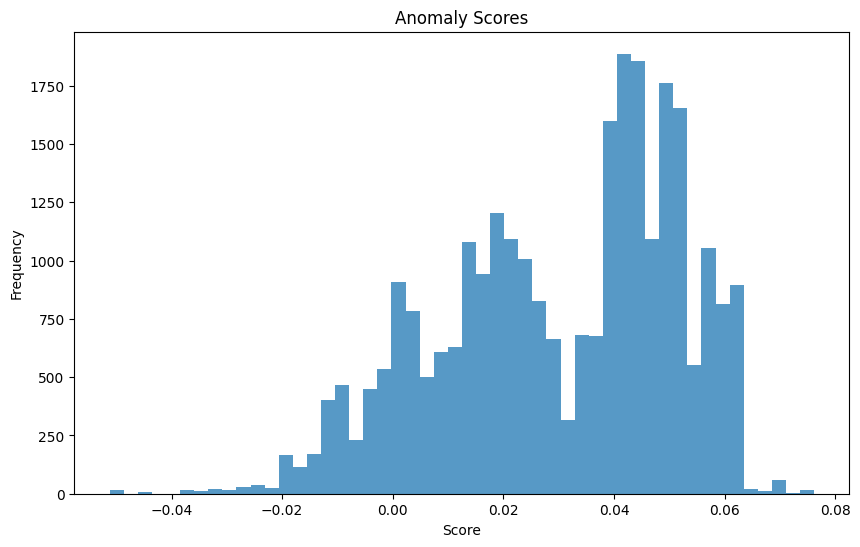

In [13]:

# Sort by anomaly score to inspect the most anomalous points
sorted_data = gl_data.sort_values(by='anomaly_score')

# Display the top 10 most anomalous points
print("Top 10 Anomalous Points:\n", sorted_data.head(10))

# Plot the anomaly scores
plt.figure(figsize=(10, 6))
plt.hist(gl_data['anomaly_score'], bins=50, alpha=0.75)
plt.title('Anomaly Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()